In [1]:
import timeit
import numpy as np
from functools import partial
import matplotlib.pyplot as plt

from skimage.filters import gaussian, threshold_otsu
from skimage.measure import label

import pyclesperanto_prototype as prototype
from pyclesperanto import Clesperanto

pyclic = Clesperanto()
pyclic.set_wait_for_kernel_to_finish(True)

prototype.select_device()
prototype.set_wait_for_kernel_finish(True)

sizes = [128, 256, 512, 1024, 2048, 4096]
warmup_iter = 3
eval_iter = 5

In [2]:
def benchmark_function(target_function):
    """
    Tests a function on a couple of image sizes and returns times taken for processing.
    """
    benchmark_data = []
    for size in sizes:
        # make new data
        image = np.random.rand(size, size)
        # bind target function to given image
        partial_function = partial(target_function, image)
        # warmup       
        warm_up_time_in_s = timeit.timeit(partial_function, number=warmup_iter)
        # measure execution time
        time_in_s = timeit.timeit(partial_function, number=eval_iter)
        # store results
        benchmark_data.append([size*4, time_in_s])
    return np.asarray(benchmark_data)

# Prototype

In [3]:
def prototype_function(image):
    blurred = prototype.gaussian_blur(source=image, sigma_x=3, sigma_y=3, sigma_z=3)
    binary = prototype.threshold_otsu(source=blurred)
    labeled = prototype.connected_components_labeling_box(binary_input=binary)
    return prototype.pull(labeled)

In [4]:
benchmark_data_prototype = benchmark_function(prototype_function)

# Pyclic

In [5]:
def pyclic_function(image):
    blurred = pyclic.gaussian_blur(input_image=image, sigma_x=3, sigma_y=3, sigma_z=3)
    binary = pyclic.threshold_otsu(input_image=blurred)
    labeled = pyclic.connected_components_labeling_box(input_image=binary)
    return pyclic.pull(labeled)

In [6]:
benchmark_data_pyclic = benchmark_function(pyclic_function)

# Skimage

In [7]:
def skimage_function(image):
    blurred = gaussian(image, sigma=3)
    binary = blurred > threshold_otsu(blurred)
    labeled = label(binary)
    return labeled

In [8]:
benchmark_data_skimage = benchmark_function(skimage_function)

# Quantification

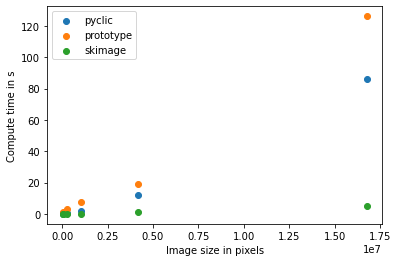

In [9]:
plt.scatter(benchmark_data_pyclic[:,0] ** 2, benchmark_data_pyclic[:,1])
plt.scatter(benchmark_data_prototype[:,0] ** 2, benchmark_data_prototype[:,1])
plt.scatter(benchmark_data_skimage[:,0] ** 2, benchmark_data_skimage[:,1])

plt.legend(["pyclic", "prototype", "skimage"])
plt.xlabel("Image size in pixels")
plt.ylabel("Compute time in s")
plt.show()